## Using Rapid Adiabatic Passage over a logic error correcting space 

The Hamiltonian describing the system is:

$H(t) = \Omega(t)\sigma_{x} + \Delta(t)\sigma_{z}$

### Stage 1 - Simulating Rapid Adiabatic Passage on a physical qubit
* Applying RAP
* Adding noise (classical)
* Fidelity calculations

### Stage 2 - Applying RAP over a logic space (QEC)
* Generating an error correctable space according to the 5-qubit code
* Apply RAP

### Stage 3 - Simulating noise
* Adding noise (classical)
* Fidelity calculations 
* Adding $H_p$

https://arxiv.org/pdf/quant-ph/0512170

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [4]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

Text(0.5, 1.0, 'Pulses over time')

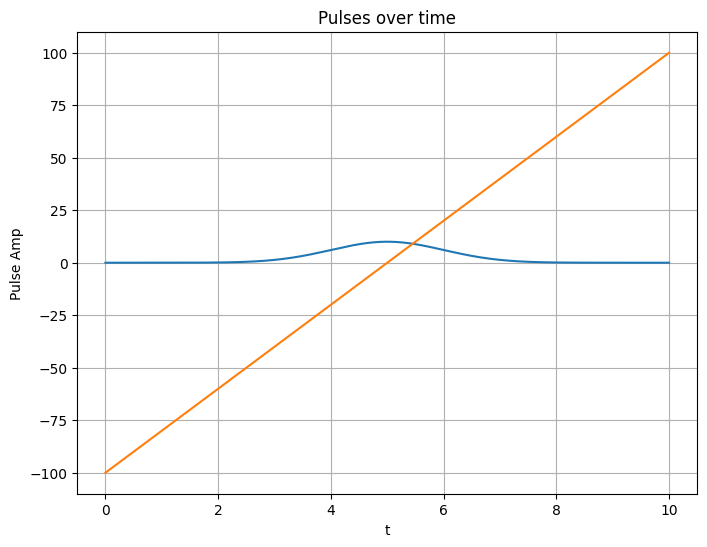

In [5]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 10 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t)
plt.plot(t, delta_t)
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.title("Pulses over time")


### Stage 1 - Simulating Rapid Adiabatic Passage on a physical qubit
* Applying RAP
* Adding noise
* Fidelity calculations

##### First, plotting the eigenvalues as function of time

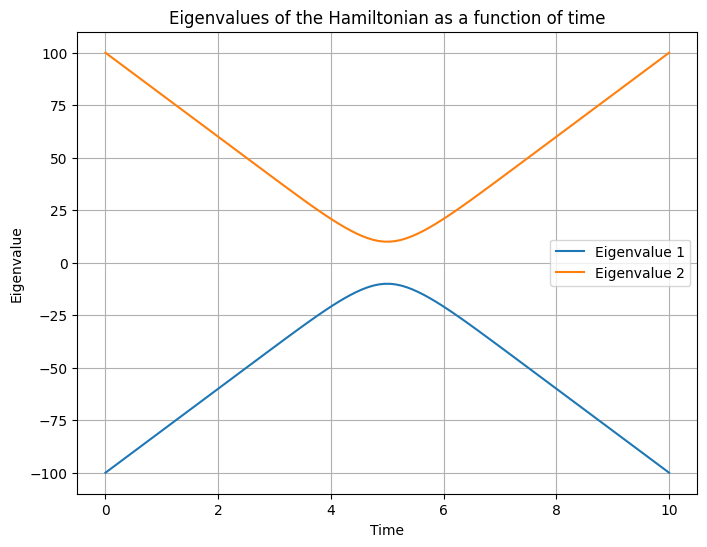

In [6]:
omega_t_f = lambda t: 10 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t_f = lambda t: 100*(t / (T/2) - 1)


tlist = np.linspace(0, 10, 100)  # from 0 to 10 with 100 points

def H_t(t):
    return omega_t_f(t) * sigmax() + delta_t_f(t) * sigmaz()

eigenvalues = np.array([H_t(t).eigenenergies() for t in tlist])

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
for i in range(eigenvalues.shape[1]):
    plt.plot(tlist, eigenvalues[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('Time')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian as a function of time')
plt.legend()
plt.grid(True)
plt.show()

##### Generating the Hamiltonian and solving using sesolve

Text(0, 0.5, 'Overlap')

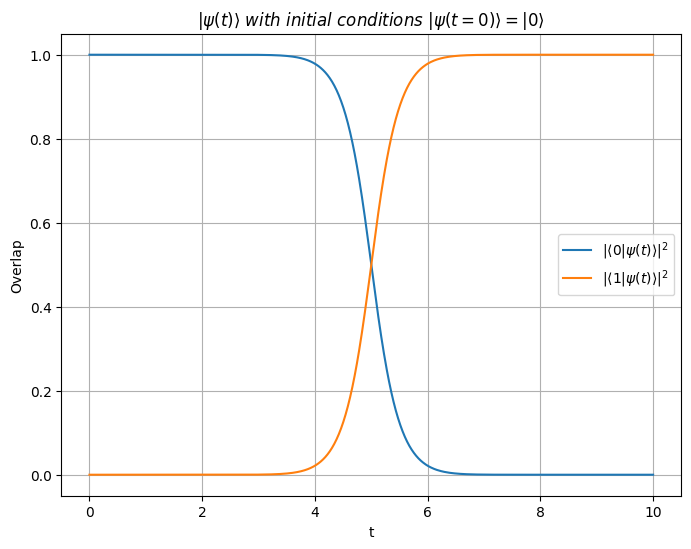

In [8]:
H = [[sigmax(), omega_t], [sigmaz(), delta_t]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H, psi0, t)
# output = sesolve(H, psi0, t)

expect_psi_0 = []
expect_psi_1 = []
for state in output.states:
    expect_stat_psi_0 = np.abs(psi0.overlap(state))**2
    expect_stat_psi_1 = np.abs(psi1.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)
    
eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0 \rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0 | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1 | \psi(t) \rangle|^2$')
plt.legend()
plt.grid(True)
plt.xlabel("t")
plt.ylabel("Overlap")

## Adding noise

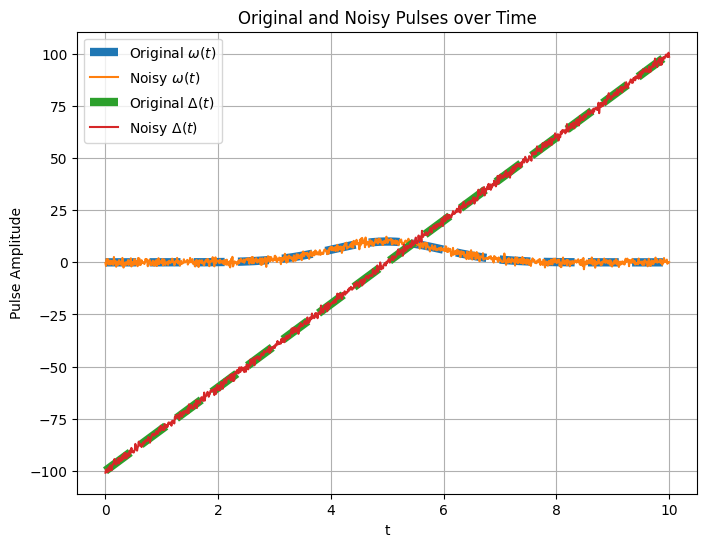

In [7]:
# Adding noise to the pulses
t = np.linspace(0, T, 1000)
noise_strength = 1
omega_t_noisy = omega_t + noise_strength * np.random.normal(size=len(t))
delta_t_noisy = delta_t + noise_strength * np.random.normal(size=len(t))

# Plot the original and noisy pulses
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'Original $\omega(t)$', linewidth=6, linestyle='--')
plt.plot(t, omega_t_noisy, label=r'Noisy $\omega(t)$')
plt.plot(t, delta_t, label=r'Original $\Delta(t)$', linewidth=6, linestyle='--')
plt.plot(t, delta_t_noisy, label=r'Noisy $\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amplitude")
plt.title("Original and Noisy Pulses over Time")
plt.grid(True)
plt.legend()
plt.show()

## Solving the noisy Hamiltonian

Text(0, 0.5, 'Overlap')

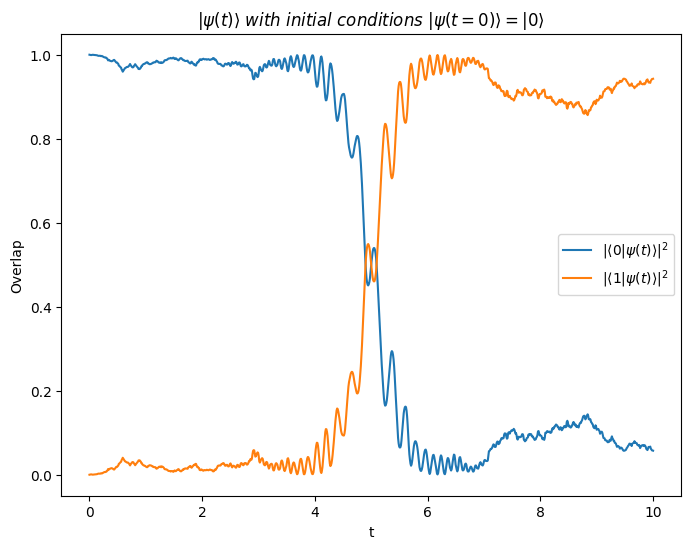

In [8]:
H_noisy = [[sigmax(), omega_t_noisy], [sigmaz(), delta_t_noisy]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H_noisy, psi0, t)

expect_psi_0 = []
expect_psi_1 = []
for state in output.states:
    expect_stat_psi_0 = np.abs(psi0.overlap(state))**2
    expect_stat_psi_1 = np.abs(psi1.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)
    
eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0 \rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0 | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1 | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Overlap")

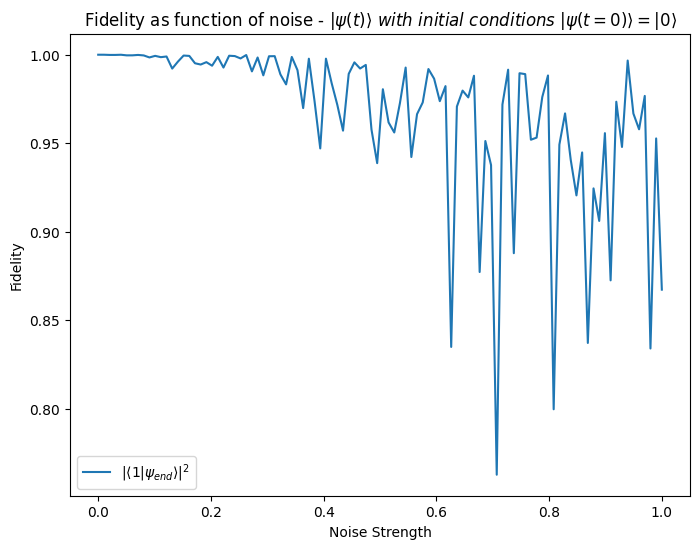

In [9]:
noise_strength = np.linspace(0, 1, 100)
fidelity_vec = []

for noise in noise_strength:
    omega_t_noisy = omega_t + noise * np.random.normal(size=len(t))
    delta_t_noisy = delta_t + noise * np.random.normal(size=len(t))
    
    H_noisy = [[sigmax(), omega_t_noisy], [sigmaz(), delta_t_noisy]]
    
    output = mesolve(H_noisy, psi0, t, [])
    
    # Get the final state
    output_state = output.states[-1]
    
    # Calculate fidelity
    fidelity = np.abs(psi1.overlap(output_state))**2
    fidelity_vec.append(fidelity)

# Plotting the fidelity as a function of noise
plt.figure(figsize=(8, 6))
plt.title(r'Fidelity as function of noise - $| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0 \rangle$')
plt.plot(noise_strength, fidelity_vec, label=r'$|\langle 1 | \psi_{end} \rangle|^2$')
plt.legend()
plt.xlabel("Noise Strength")
plt.ylabel("Fidelity")
plt.show()

### Stage 2 - Applying RAP over a logic space (QEC)
* Generating an error correctable space according to the 5-qubit code
* Apply RAP

Generating the logic space and checking if ARP manages to move the logic zero to logic one 

Working with the stabilizer formalism


In [11]:
def is_stabilized(state, stabilizers):
    """
    Check if a state is stabilized
    """
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.real(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
            
    return syndrome, stabilized, overlaps

In [15]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
stabilizers = [
    tensor(X, Z, Z, X, I),
    tensor(I, X, Z, Z, X),
    tensor(X, I, X, Z, Z),
    tensor(Z, X, I, X, Z)
]

basis_states = [basis(2, 0), basis(2, 1)]

logical_X = tensor(X, X, X, X, X)
# logical_X = -tensor(X, I, Y, Y, I)

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[1], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[0], basis_states[1]) +
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[1], basis_states[1]) +
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[0], basis_states[1])).unit()


logical_one = logical_X * logical_zero

# Applying error
error = tensor(I, I, I, X, I)
logical_zero = error * logical_zero
logical_one = error * logical_one

result_zero = is_stabilized(logical_zero, stabilizers)
result_one = is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")
# print(print_quantum_state_as_superposition(logical_zero))
# print(print_quantum_state_as_superposition(logical_one))

Logical |0_L> is stabilized: False and the syndrom is [0, 1, 1, 0]
Logical |1_L> is stabilized: False and the syndrom is [0, 1, 1, 0]


## Trying to flip a logical zero into a logical one

In [18]:
H0 = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H1 = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

# Define time-dependent Hamiltonian
H = [[H0, omega_t], [H1, delta_t]]

# solving using sesolve
output = sesolve(H, logical_zero, t)

logical_one = output.states[-1]
# print_quantum_state_as_superposition(logical_one)

|ψ⟩ = - 0.25|00001⟩ + 0.25|00010⟩ - 0.25|00100⟩ + 0.25|00111⟩ + 0.25|01000⟩ + 0.25|01011⟩ - 0.25|01101⟩ - 0.25|01110⟩ + 0.25|10000⟩ - 0.25|10011⟩ - 0.25|10101⟩ + 0.25|10110⟩ - 0.25|11001⟩ - 0.25|11010⟩ - 0.25|11100⟩ - 0.25|11111⟩
|ψ⟩ = - 0.25|00000⟩ - 0.25|00011⟩ - 0.25|00101⟩ - 0.25|00110⟩ + 0.25|01001⟩ - 0.25|01010⟩ - 0.25|01100⟩ + 0.25|01111⟩ - 0.25|10001⟩ - 0.25|10010⟩ + 0.25|10100⟩ + 0.25|10111⟩ + 0.25|11000⟩ - 0.25|11011⟩ + 0.25|11101⟩ - 0.25|11110⟩


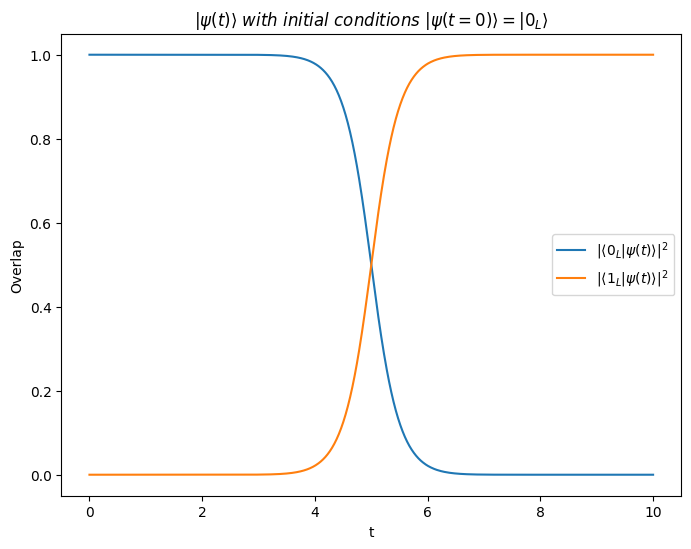

In [19]:
expect_psi_0 = []
expect_psi_1 = []

for index, state in enumerate(output.states):
    if index == 0 or index == len(output.states) - 1:
        print_quantum_state_as_superposition(state)
    expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
    expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)

eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

Checking over a noisy Hamiltonian

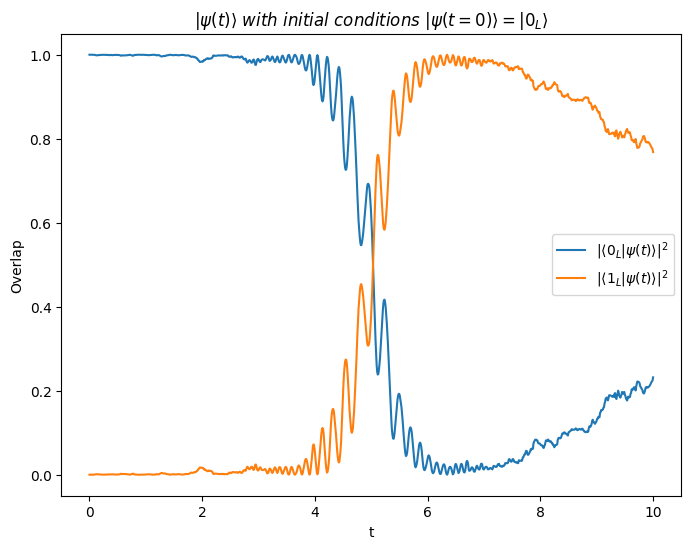

In [20]:
# Adding noise to the pulses
noise_strength = 1
omega_t_noisy = omega_t + noise_strength * np.random.normal(size=len(t))
delta_t_noisy = delta_t + noise_strength * np.random.normal(size=len(t))

H0 = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H1 = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

H_noisy = [[H0, omega_t_noisy], [H1, delta_t_noisy]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H_noisy, logical_zero, t)

expect_psi_0 = []
expect_psi_1 = []
for index, state in enumerate(output.states):
    expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
    expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)

eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

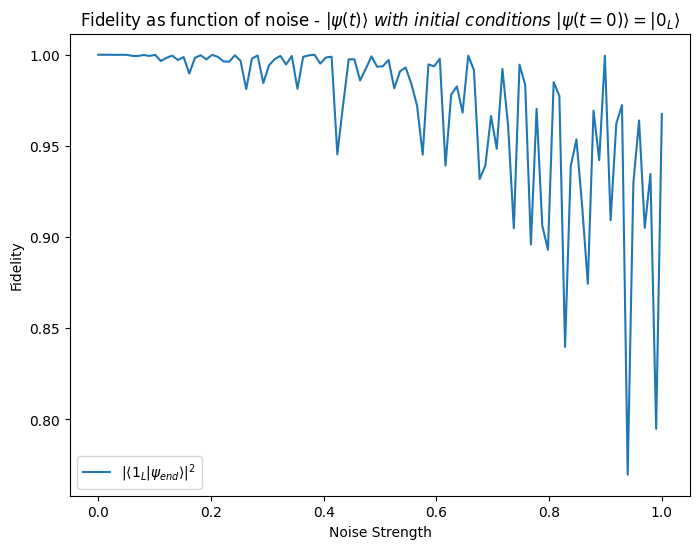

In [21]:
noise_strength = np.linspace(0, 1, 100)
fidelity_vec = []

for noise in noise_strength:
    omega_t_noisy = omega_t + noise * np.random.normal(size=len(t))
    delta_t_noisy = delta_t + noise * np.random.normal(size=len(t))
    
    H_noisy = [[H0, omega_t_noisy], [H1, delta_t_noisy]]    
    output = mesolve(H_noisy, logical_zero, t, [])
    
    # Get the final state
    output_state = output.states[-1]
    
    # Calculate fidelity
    fidelity = np.abs(logical_one.overlap(output_state))**2
    fidelity_vec.append(fidelity)

# Plotting the fidelity as a function of noise
plt.figure(figsize=(8, 6))
plt.title(r'Fidelity as function of noise - $| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0_L \rangle$')
plt.plot(noise_strength, fidelity_vec, label=r'$|\langle 1_L | \psi_{end} \rangle|^2$')
plt.legend()
plt.xlabel("Noise Strength")
plt.ylabel("Fidelity")
plt.show()

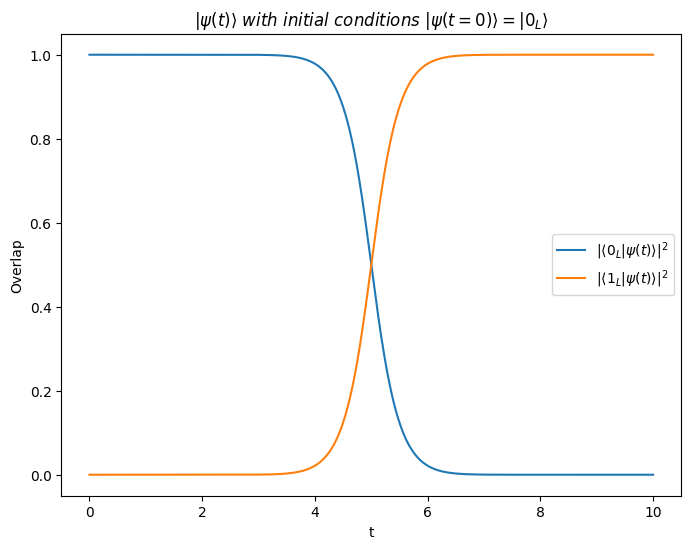

In [22]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)

sigma = 1
omega_t = 10 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 100*(t / (T/2) - 1)

I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

basis_states = [basis(2, 0), basis(2, 1)]
logical_X = tensor(X, X, X, X, X)

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[1], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[0], basis_states[1]) +
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[1], basis_states[1]) +
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[0], basis_states[1])).unit()


logical_one = logical_X * logical_zero

g1 = tensor(X, Z, Z, X, I)
g2 = tensor(I, X, Z, Z, X)
g3 = tensor(X, I, X, Z, Z)
g4 = tensor(Z, X, I, X, Z)

Ep = -0.1

Hp = -Ep*(g1 + g2 + g3 + g4)


H0 = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H1 = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())
# Define time-dependent Hamiltonian
H = [[H0, omega_t], [H1, delta_t], Hp]

# solving using sesolve
output = sesolve(H, logical_zero, t)

# logical_one = output.states[-1]

expect_psi_0 = []
expect_psi_1 = []

for index, state in enumerate(output.states):
    expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
    expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)

eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

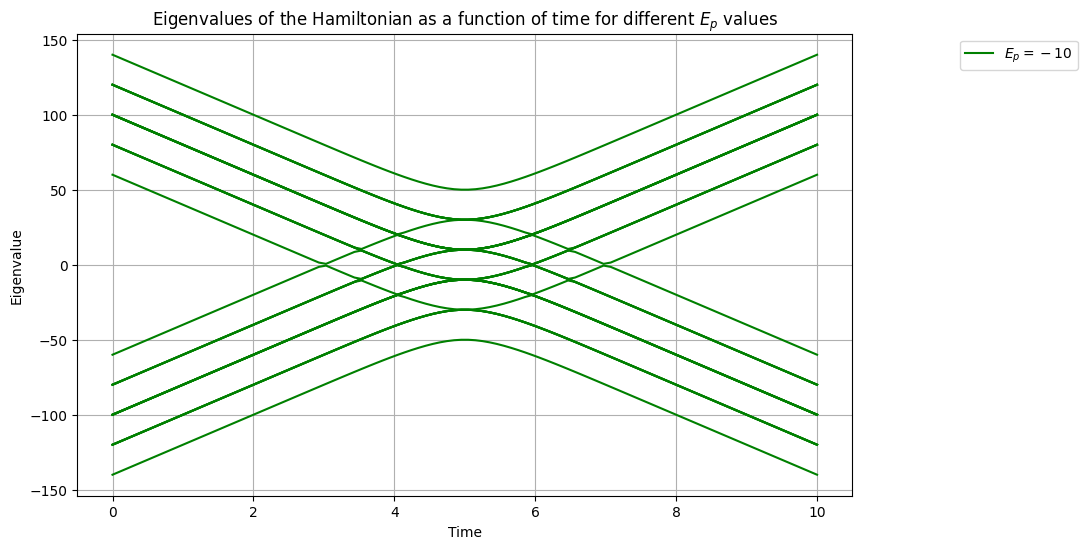

In [26]:
T = 10
tlist = np.linspace(0, T, 100)

# Define the operators
I = qeye(2)
X = sigmax()
Z = sigmaz()

# Define H0 and H1
H0 = tensor(X, X, X, X, X)
H1 = tensor(Z, Z, Z, Z, Z)

# Stabilizers
g1 = tensor(X, Z, Z, X, I)
g2 = tensor(I, X, Z, Z, X)
g3 = tensor(X, I, X, Z, Z)
g4 = tensor(Z, X, I, X, Z)

def H_t(t, Ep):
    omega_t = omega_t_f(t)
    delta_t = delta_t_f(t)
    Hp = -Ep * (g1 + g2 + g3 + g4)
    return omega_t * H0 + delta_t * H1 + Hp

# Define Ep values to test
# Ep_values = [10, 1, 0, -0.1, -0.5, -1.0, -2.0]
# colors = ['yellow', 'orange', 'white' ,'blue', 'green', 'red', 'purple']
Ep_values = [-10]
colors = ['g']
plt.figure(figsize=(10, 6))

for Ep, color in zip(Ep_values, colors):
    eigenvalues = np.array([H_t(t, Ep).eigenenergies() for t in tlist])
    plt.plot(tlist, eigenvalues, color=color)
    # for i in range(eigenvalues.shape[1]):
    #     plt.plot(tlist, eigenvalues[:, i], color=color, alpha=0.6)

# Add a legend for the Ep values
for Ep, color in zip(Ep_values, colors):
    plt.plot([], [], color=color, label=f'$E_p={Ep}$')

plt.xlabel('Time')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian as a function of time for different $E_p$ values')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


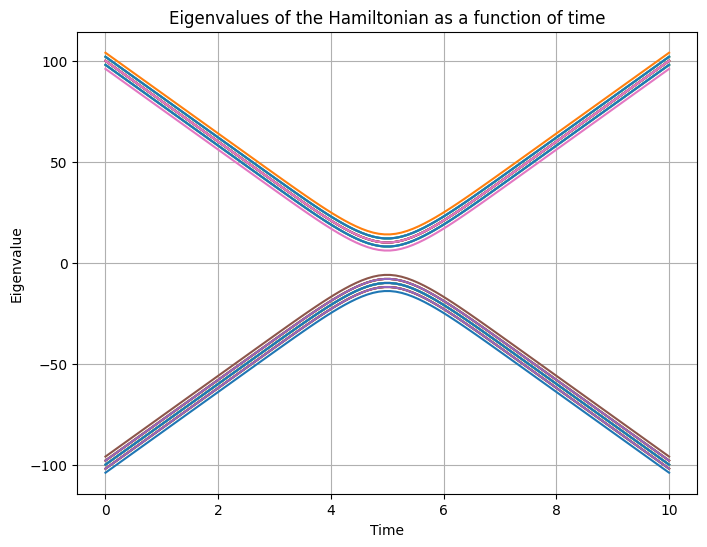

In [24]:
omega_t_f = lambda t: 10 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t_f = lambda t: 100*(t / (T/2) - 1)

# Define H0 and H1
H0 = tensor(X, X, X, X, X)
H1 = tensor(Z, Z, Z, Z, Z)

tlist = np.linspace(0, 10, 100)  # from 0 to 10 with 100 points

# Stabilizers
g1 = tensor(X, Z, Z, X, I)
g2 = tensor(I, X, Z, Z, X)
g3 = tensor(X, I, X, Z, Z)
g4 = tensor(Z, X, I, X, Z)

def H_t(t, Ep):
    omega_t = omega_t_f(t)
    delta_t = delta_t_f(t)
    Hp = -Ep * (g1 + g2 + g3 + g4)
    return omega_t * H0 + delta_t * H1 + Hp


Ep_values = [1]
colors = ['g']

# Plot the eigenvalues
plt.figure(figsize=(8, 6))

for Ep in Ep_values:
    eigenvalues = np.array([H_t(t, Ep).eigenenergies() for t in tlist])
    for i in range(eigenvalues.shape[1]):
        plt.plot(tlist, eigenvalues[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('Time')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian as a function of time')
plt.grid(True)
plt.show()